## Day 2: Let the Tensors Flow!

Welcome to Day 2! Today, we start with our discussion with an introduction to TensorFlow followed by implementation of Numerical Integration techniques in TensorFlow.

### An Introduction to TensorFlow

TensorFlow is an open-source software library. TensorFlow was originally developed by researchers and engineers working on the Google Brain Team within Google’s Machine Intelligence research organization for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well!

Essentially, TensorFlow library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers. It is a python package that (much like BLAS on Intel MKL) speeds up Linear Algebra Computation. What is special about this system is that it is capable of utilizing GPUs and TPUs for computation and its written in a simpler language like python.

#### Why GPU/TPU vs CPU?

<img src="GPUvCPU.png" alt="GPUvCPU.png" width="600"/>

The answer lies in the architecture: 
**CPU = Faster per Core Processing, Slow but Large Memory Buffer, Few Cores**
**GPU/TPU = Slower Processing, Faster but Smaller Memory Buffer, Many Cores**

Thus GPUs and TPUs are optimized for large number of simple calculations done parallely. The extent of this  parallelization makes it suitable for vector/tensor manipulation.

#### How TensorFlow works?

TensorFlow essentially performs numerical computations on multidimensional arrays (called tensors) using "data flow graphs" or "computation graphs". In these graphs, nodes represent variables/placeholders/constants or mathematical operations such as matrix multiplication or elementwise addition and the edges in the graph represent the flow of tensors between operations (nodes). Tensor is the central unit of data in TensorFlow giving the package its name. For example, look at the following computation graph:


Here, "matmul" is a node which represents the matrix multiplication operation. a and b are input matrices (2-D tensors) and c is the resultant matrix.

#### Implementing a computational graph in TensorFlow

In [46]:
# Firstly, import TensorFlow, Numpy, and Matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Creating nodes in the computation graph 
a = tf.constant([[1.],[2.],[3.]], dtype=tf.float64) # a 3x1 column matrix 
b = tf.constant([[1.,2.,3.]], dtype=tf.float64) # a 1x3 row matrix 
c = tf.matmul(a, b) 

# To run the graph, we need to create a session.
# Creating the session initializes the computational device.

sess = tf.Session() # start a session
output = sess.run(c) # compute the value of c
sess.close() # end the session

print(output)

# TO automatically close the session after computation, Use:
# with tf.Session() as sess:
#    output = sess.run(c) 

[[1. 2. 3.]
 [2. 4. 6.]
 [3. 6. 9.]]


#### Iterating recursively over in TensorFlow

Say, one wants to recursively apply a function on an initial value but the function takes in additional input at every recursive call, for example, to find a cumulative sum over a list. Every step is addition of the new element from the list onto the last addition. The TensorFlow function tf.scan allows us to easily implement such an iterator.

In [47]:
# define the recursive function that takes in two values the
# accumulated value and the additional input from a list.
def recursive_addition(accumulator,new_element):
    return accumulator+new_element

# define the list over which we iterate
elems = np.array([1, 2, 3, 4, 5, 6])

# tf.scan takes in three inputs: the recursive function, the 
# list to iterate over and the initial value. If an initial 
# value is not provided, its taken as the first element of elems.

# accumulate with no initializer
cum_sum_a = tf.scan(recursive_addition, elems) 
# accumulate with initializer as the number 5
cum_sum_b = tf.scan(recursive_addition, elems, tf.constant(5,dtype=tf.int64))

with tf.Session() as sess:
    output_a = sess.run(cum_sum_a)
    output_b = sess.run(cum_sum_b)

print(output_a)
print(output_b)

[ 1  3  6 10 15 21]
[ 6  8 11 15 20 26]


As an **Exercise** try using tf.scan to compute the fibonacci sequence.

One may have noticed that our integration is essentially an recursive process over the time series. Both the updation rules can just be written as a recursive function $F$ such that $X_{i+1}=F(X_i,t_i,\epsilon_i)$. We would want our output to be the array $[X_0,F(X_0,t_0,\epsilon_0),F(F(X_0,t_0,\epsilon_0),t_1,\epsilon_1)...]$. To get this, we just need to recursively iterate over the array of time and $\epsilon$ and apply a updation function $F$ recursively on the initial condition, which exactly what tf.scan enables us to do.

#### Euler Integration Function in TensorFlow

Transitioning to TensorFlow is not a trivial process, but once you get a gist of how it works, it is as simple as using numpy. Because of the way the TensorFlow architecture is designed, there are a few limitations to how one can do simpler operations/manipulation. But it is easy to overcome using the correct function and code patterns which can be easily learnt.

In [48]:
def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating): 
        # The datatype of any tensor t is accessed by t.dtype
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        
        time_delta_grid = t[1:] - t[:-1]  
        
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = dt*func(y,t)
            return y + dy
        
        # iterating over (a,b) where a and b are lists of same size
        # results in the ith accumulative step in tf.scan receiving
        # the ith elements of a and b zipped together
        
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0) 
        return tf.concat([[y0], y], axis=0)

def tf_odeint_euler(func, y0, t):
    
    # Convert input to TensorFlow Objects
    
    t = tf.convert_to_tensor(t, preferred_dtype=tf.float64, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator().integrate(func,y0,t)

#### Running the TensorFlow Euler Integrator

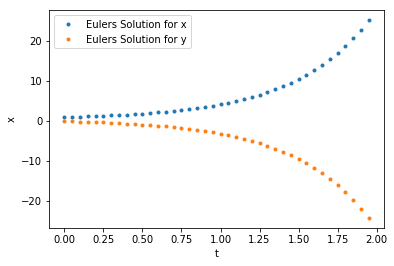

In [55]:
# Define a function using Tensorflow math operations. This creates a computational graph.

def f(X,t):
    # extracting a single value eg. X[0] returns a single value but
    # we require a tensor, so we extract a range with one element.
    x = X[0:1] 
    y = X[1:2]
    out = tf.concat([x-y,y-x],0)
    return out

y0 = tf.constant([1,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,2,epsilon)

# Define the final value (output of scan) that we wish to compute as a variable

state = tf_odeint_euler(f,y0,t)

# Start a TF session and evaluate state
with tf.Session() as sess:
    state = sess.run(state)

plt.plot(t[::5],state.T[0,::5],".",label="Eulers Solution for x")
plt.plot(t[::5],state.T[1,::5],".",label="Eulers Solution for y")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

#### RK4 Integration Function in TensorFlow

Now, we implement the exact same RK4 integrator in TensorFlow.

In [53]:
import tensorflow as tf

def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        time_delta_grid = t[1:] - t[:-1]
        
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            return y + dy

        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    def _step_func(self, func, t, dt, y):
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def tf_odeint_rk4(func, y0, t):
    t = tf.convert_to_tensor(t, preferred_dtype=tf.float64, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator().integrate(func,y0,t)

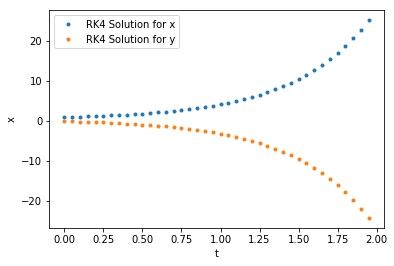

In [56]:
# Define a function using Tensorflow math operations. This creates a computational graph.

def f(X,t):
    # extracting a single value eg. X[0] returns a single value but
    # we require a tensor, so we extract a range with one element.
    x = X[0:1] 
    y = X[1:2]
    out = tf.concat([x-y,y-x],0)
    return out

y0 = tf.constant([1,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,2,epsilon)

# Define the final value (output of scan) that we wish to compute as a variable

state = tf_odeint_rk4(f,y0,t)

# Start a TF session and evaluate state
with tf.Session() as sess:
    state = sess.run(state)

plt.plot(t[::5],state.T[0,::5],".",label="RK4 Solution for x")
plt.plot(t[::5],state.T[1,::5],".",label="RK4 Solution for y")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()